In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import h3
import folium
from shapely.geometry import Polygon
import geopandas as gpd

# Get the data needed

In [2]:
order = pd.read_csv(r'C:\Users\lehon\Documents\casestudydata\Python projects\datasets\data_orders.csv')
offer = pd.read_csv(r'C:\Users\lehon\Documents\casestudydata\Python projects\datasets\data_offers.csv')

In [3]:
df1 = order.merge(offer, how='inner', on='order_gk')

df1.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In [4]:
df1.tail()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
31263,12:44:11,-0.975372,51.457846,NaN,3000597886155,4,0,43.0,300051590196
31264,12:42:52,-0.975372,51.457846,NaN,3000597886140,4,0,44.0,300051590176
31265,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,300051648809
31266,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,300051648910
31267,11:49:35,-0.974738,51.458180,177.0,3000592871241,4,1,40.0,300051391527


# Analyse reason for failure

In [5]:
#Get the data needed

df2 = order.groupby(['is_driver_assigned_key','order_status_key'], as_index=False).size()
list=[]
for i, row in df2.iterrows():
    if row['order_status_key']==4:
        list.append('guest_cancel')
    else:
        list.append('system_cancel')
list1=[]
for i, row in df2.iterrows():
    if row['is_driver_assigned_key']==1:
        list1.append('assigned')
    else:
        list1.append('not_assigned')
        
        
df2['status']=list
df2['driver_assigned'] = list1
df2['count'] = df2['size']
df3 = df2.drop(['order_status_key','is_driver_assigned_key','size'], axis=1).sort_values(by='status')
df3

,status,driver_assigned,count
0,guest_cancel,not_assigned,4496
2,guest_cancel,assigned,2811
1,system_cancel,not_assigned,3406
3,system_cancel,assigned,3


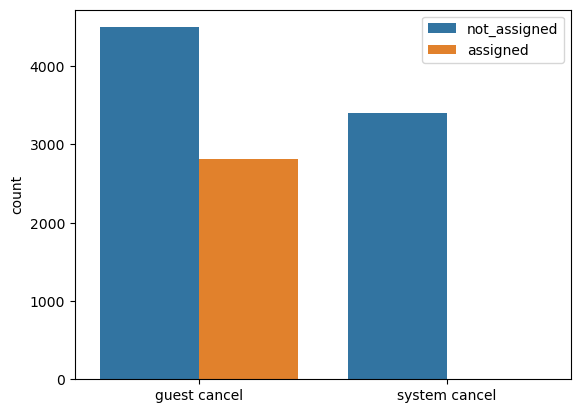

In [6]:
#Visualization

sns.barplot(x='status', y='count', hue='driver_assigned',data=df3)
plt.xticks([0,1],['guest cancel','system cancel'])
plt.xlabel(None)
plt.legend()

Text(0.5, 1.0, 'Cancellation type')

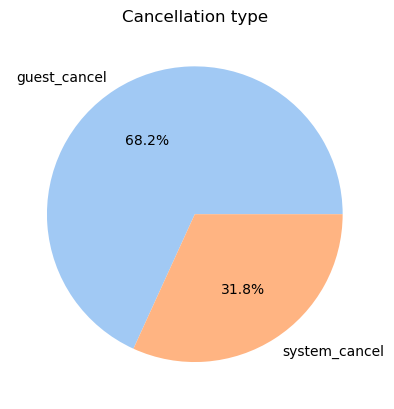

In [7]:
df4 = df3.groupby('status', as_index=False)['count'].sum()
labels = df4['status']
data = df4['count']


colors = sns.color_palette('pastel')
plt.pie(x=data, labels = labels, colors=colors,autopct='%1.1f%%' )
plt.title('Cancellation type')

Text(0.5, 1.0, 'Guest cancel')

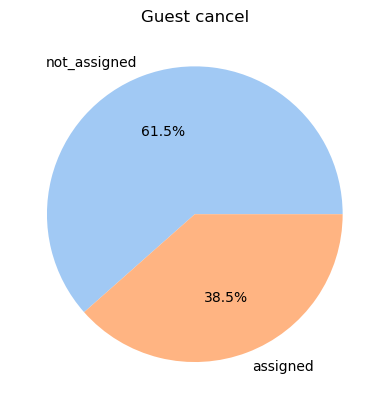

In [8]:
labels = df3[df3['status']=='guest_cancel']['driver_assigned']
data = df3[df3['status']=='guest_cancel']['count']
colors = sns.color_palette('pastel')


plt.pie(x = data, labels=labels, colors=colors, autopct='%1.1f%%')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Guest cancel')

Text(0.5, 1.0, 'System cancel')

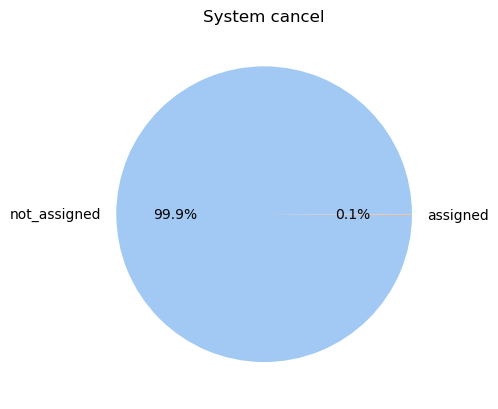

In [9]:
labels = df3[df3['status']=='system_cancel']['driver_assigned']
data = df3[df3['status']=='system_cancel']['count']
colors = sns.color_palette('pastel')


plt.pie(x = data, labels=labels, colors=colors, autopct='%1.1f%%')
plt.xlabel(None)
plt.ylabel(None)
plt.title('System cancel')

The majority of the reason for failure is due to guest cancellation with 61.5% of the case that driver haven't been assigned, 38.5% have been assigned. In case of system cancellation almost all the case that driver is not assigned except 3 cases

# Analyse the trend of failing orders

Text(0.5, 1.0, 'Trend of failing orders by hour')

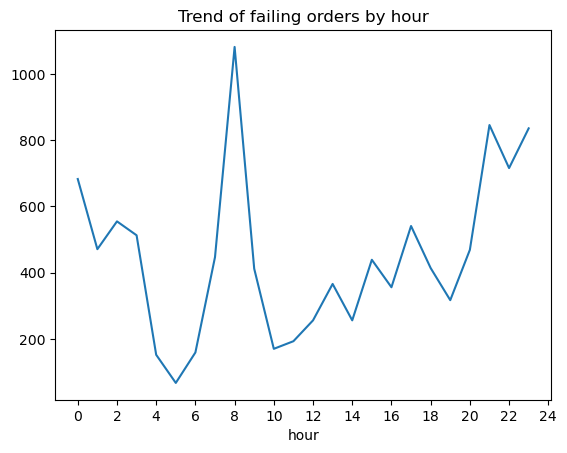

In [20]:
order['hour'] = pd.to_datetime(order['order_datetime']).dt.hour


order.groupby('hour', as_index=False).size().plot(kind='line', x='hour', y='size', legend=None)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
plt.title('Trend of failing orders by hour')


The hour around 7-9 am are the highest in number of failing order this is the time when most people go to work which can cause traffic jam lead to the wait time for driver take longer and high in taxi demand which lead to high failing orders. The system can also cancel the order if driver take to long to come due to traffic. The second time that have highest failing order is around 9-11 pm this could be due to the increasing demand from customer, or it could be due to safety that drivers avoid take order around this hour 

# Average time to cancellation with and without driver, by the hour

In [11]:
#Find the upper and lower limit to remove outliner

order_no_nan = order.dropna()
q1 = np.percentile(order_no_nan['cancellations_time_in_seconds'],25)
q3 = np.percentile(order_no_nan['cancellations_time_in_seconds'],75)
IQR = q3 - q1
lower = q1 - 1.5*IQR
upper = q3 + 1.5*IQR

Text(0.5, 1.0, 'Mean time to cancelation without driver')

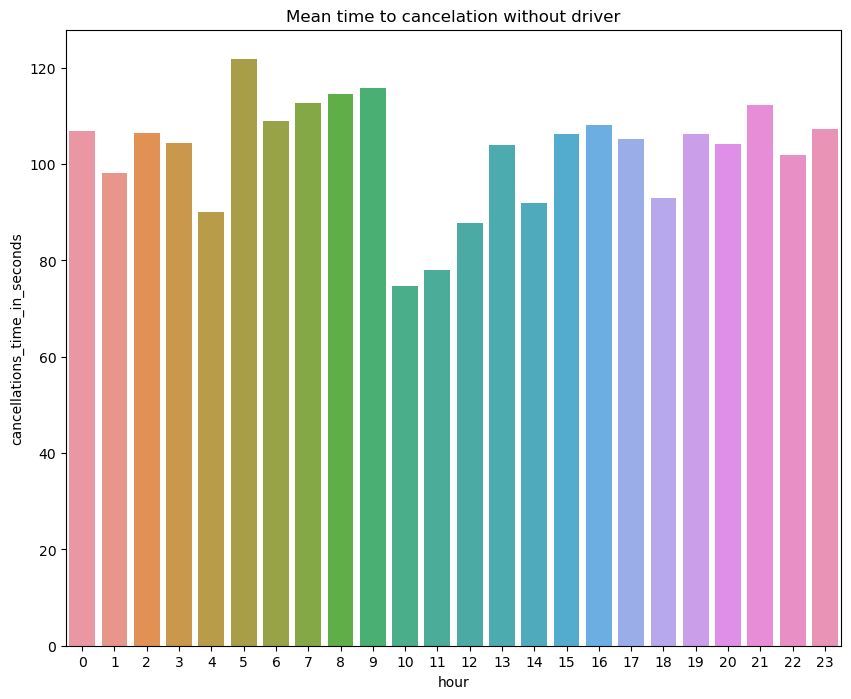

In [12]:
boxplotdata = order[np.logical_and(order['is_driver_assigned_key']==0,order['cancellations_time_in_seconds'] < upper, order['cancellations_time_in_seconds'] > lower )]
barplotdata = boxplotdata.groupby('hour', as_index=False)['cancellations_time_in_seconds'].mean()


plt.figure(figsize=(10,8))
sns.barplot(data=barplotdata, x='hour',  y='cancellations_time_in_seconds')
plt.title('Mean time to cancelation without driver')

Text(0.5, 1.0, 'Mean time to cancelation with driver')

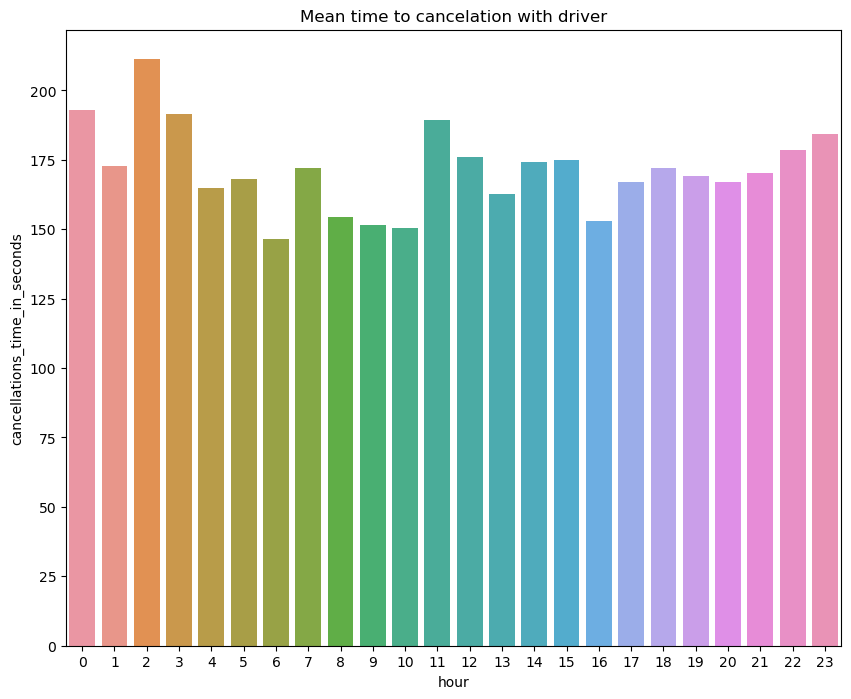

In [13]:
boxplotdata1 = order[np.logical_and(order['is_driver_assigned_key']==1,order['cancellations_time_in_seconds'] < upper, order['cancellations_time_in_seconds'] > lower )]
barplotdata1 = boxplotdata1.groupby('hour', as_index=False)['cancellations_time_in_seconds'].mean()


plt.figure(figsize=(10,8))
sns.barplot(data=barplotdata1, x='hour',  y='cancellations_time_in_seconds')
plt.title('Mean time to cancelation with driver')

We can see that the mean time to cancelation is lower when there are no driver comparing to the case if there is driver assigned and around 9-11 mean cancelation time will be lower without driver and around 9-10 am with driver

# Analyse ETA trend

Text(0.5, 1.0, 'Average ETA by hour')

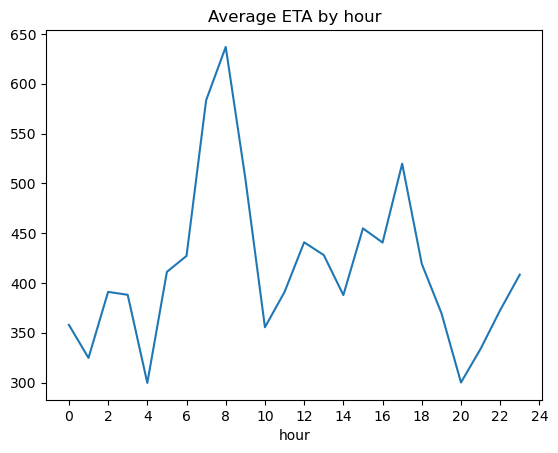

In [21]:
order.groupby('hour')['m_order_eta'].mean().plot()
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
plt.title('Average ETA by hour')

 We can see that the trend of average ETA by hour reach highest around 7-9 am which is reasonable due to the highest number of failing order analyse above also fall into this time range. This can be due to the high demand at peak hour that increased the waiting time of the customer. Moreover, there is another peak time around 5-6 pm. The reason for high waiting hour due to during this time people have high demand to book vehicle to go home, go out for other activities  

# Hexagon

In [28]:
order["h3_code"] = order.apply(lambda row: h3.geo_to_h3(row["origin_latitude"], row["origin_longitude"], 8), axis=1)

In [29]:
order

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour,h3_code
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,88195d2b03fffff
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20,88195d2b19fffff
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,88195d2b1dfffff
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,88195d7497fffff
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21,88195d2b1dfffff
...,...,...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,13,88195d2b03fffff
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0,13,88195d2b03fffff
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,13,88195d2b1dfffff
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0,13,88195d2b03fffff


In [39]:
hex_df = order.groupby("h3_code").agg({"order_gk": "count"}).reset_index().sort_values(by='order_gk', ascending=False)
hex_df["cum_perc"] = round(hex_df["order_gk"].cumsum() / hex_df["order_gk"].sum() * 100,2)
hex_df[hex_df['cum_perc'] <= 80]

,h3_code,order_gk,cum_perc
97,88195d2b1dfffff,1497,13.97
96,88195d2b1bfffff,870,22.09
93,88195d2b15fffff,774,29.31
91,88195d2b11fffff,707,35.91
95,88195d2b19fffff,667,42.13
20,88195d284dfffff,653,48.23
63,88195d2a27fffff,414,52.09
89,88195d2b0bfffff,372,55.56
62,88195d2a25fffff,362,58.94
92,88195d2b13fffff,346,62.17


In [42]:
def h3_to_polygon(h3_code): return Polygon(h3.h3_to_geo_boundary(h3_code, geo_json=True))

In [46]:
hex_gdf = gpd.GeoDataFrame(hex_df, geometry=hex_df["h3_code"].apply(h3_to_polygon), crs="EPSG:4326")
hex_gdf

,h3_code,order_gk,cum_perc,geometry
97,88195d2b1dfffff,1497,13.97,"POLYGON ((-0.96742 51.46233, -0.97415 51.46109..."
96,88195d2b1bfffff,870,22.09,"POLYGON ((-0.95072 51.45257, -0.95745 51.45133..."
93,88195d2b15fffff,774,29.31,"POLYGON ((-0.97532 51.45658, -0.98205 51.45534..."
91,88195d2b11fffff,707,35.91,"POLYGON ((-0.96302 51.45458, -0.96975 51.45333..."
95,88195d2b19fffff,667,42.13,"POLYGON ((-0.95512 51.46033, -0.96185 51.45908..."
...,...,...,...,...
7,88195d281dfffff,1,99.96,"POLYGON ((-0.93664 51.40804, -0.94337 51.40680..."
8,88195d2821fffff,1,99.97,"POLYGON ((-0.98580 51.41606, -0.99252 51.41481..."
59,88195d2a1bfffff,1,99.98,"POLYGON ((-0.86471 51.43850, -0.87144 51.43726..."
142,88195d74d5fffff,1,99.99,"POLYGON ((-1.05009 51.48985, -1.05683 51.48860..."


In [55]:
m = folium.Map(location=[10.8231, 106.6297], zoom_start=10)
folium.TileLayer("OpenStreetMap").add_to(m)
folium.Choropleth(
    geo_data=hex_gdf,
    data=hex_gdf,
    columns=["h3_code", "order_gk"],
    key_on="feature.properties.h3_code",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of fails"
).add_to(m)
# get the southwest and northeast corners of the dataset
sw = order[["origin_latitude", "origin_longitude"]].min().values.tolist()
ne = order[["origin_latitude", "origin_longitude"]].max().values.tolist()

# fit the map to the bounding box
m.fit_bounds([sw, ne])
m

It is obvious that the area with highest failing orders are in the center of city which has high level of traffic during peak time which will lead to most of the failing order fall in this area